In [1]:
# ===============================
# Wildfire Prediction Project
# ===============================
# Complete pipeline for wildfire detection from satellite images

# 1. Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


Using device: cpu
Loading datasets with robust error handling...
✅ Dataset built: 30250 valid images, 0 corrupted images skipped
✅ Dataset built: 6300 valid images, 0 corrupted images skipped
✅ Dataset built: 6300 valid images, 0 corrupted images skipped
Dataset sizes:
  Training: 30250 images
  Validation: 6300 images
  Test: 6300 images
  Classes: ['nowildfire', 'wildfire']
Sample image shape (C,H,W): torch.Size([3, 224, 224])
Sample image label: nowildfire

📊 Exploratory Data Analysis:
Class imbalance ratio (max/min): 1.09


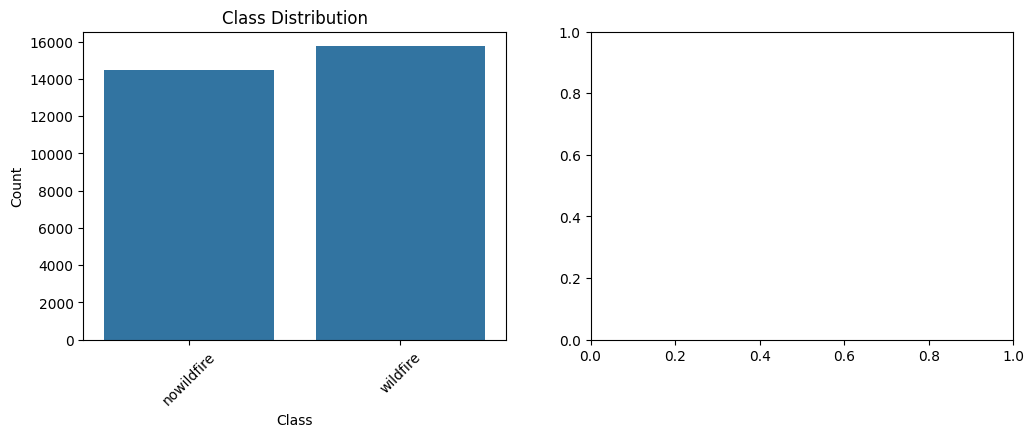

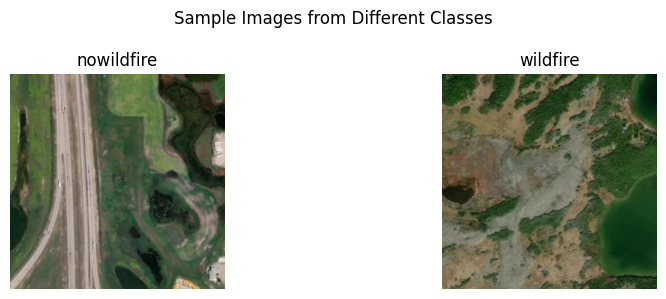

In [2]:
# ===============================
# 2. Custom Dataset Class with Error Handling
# ===============================

class RobustImageFolder(Dataset):
    """Custom dataset that handles corrupted images gracefully."""
    
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []
        self.classes = []
        self.class_to_idx = {}
        
        # Build dataset
        self._build_dataset()
    
    def _build_dataset(self):
        """Build dataset while skipping corrupted images."""
        if not os.path.exists(self.root):
            raise ValueError(f"Directory {self.root} does not exist")
        
        # Get class names
        self.classes = sorted([d for d in os.listdir(self.root) 
                              if os.path.isdir(os.path.join(self.root, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Build samples list
        corrupted_count = 0
        valid_count = 0
        
        for class_name in self.classes:
            class_dir = os.path.join(self.root, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(class_dir, filename)
                    
                    # Test if image is valid
                    if self._is_valid_image(file_path):
                        self.samples.append((file_path, class_idx))
                        valid_count += 1
                    else:
                        corrupted_count += 1
                        print(f"⚠️ Skipping corrupted image: {file_path}")
        
        print(f"✅ Dataset built: {valid_count} valid images, {corrupted_count} corrupted images skipped")
    
    def _is_valid_image(self, path):
        """Check if image file is valid and not corrupted."""
        try:
            with Image.open(path) as img:
                img.verify()  # Verify the image
            return True
        except (OSError, IOError, Image.UnidentifiedImageError):
            return False
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        
        try:
            with Image.open(path) as img:
                sample = img.convert('RGB')
            
            if self.transform is not None:
                sample = self.transform(sample)
            
            return sample, target
        
        except Exception as e:
            print(f"⚠️ Error loading image {path}: {e}")
            # Return a dummy image if loading fails
            dummy_img = Image.new('RGB', (224, 224), color='black')
            if self.transform is not None:
                dummy_img = self.transform(dummy_img)
            return dummy_img, target

# ===============================
# 3. Dataset Loading and EDA
# ===============================

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load datasets with robust error handling
print("Loading datasets with robust error handling...")
train_dataset = RobustImageFolder(root="train", transform=train_transform)
valid_dataset = RobustImageFolder(root="valid", transform=valid_test_transform)
test_dataset = RobustImageFolder(root="test", transform=valid_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Dataset overview
print(f"Dataset sizes:")
print(f"  Training: {len(train_dataset)} images")
print(f"  Validation: {len(valid_dataset)} images")
print(f"  Test: {len(test_dataset)} images")
print(f"  Classes: {train_dataset.classes}")

# Sample image check
img, label = train_dataset[0]
print(f"Sample image shape (C,H,W): {img.shape}")
print(f"Sample image label: {train_dataset.classes[label]}")

# Exploratory Data Analysis
print("\n📊 Exploratory Data Analysis:")

# Class distribution
labels = [label for _, label in train_dataset.samples]
train_labels = pd.DataFrame(labels, columns=["class_id"])
train_labels["class_name"] = train_labels["class_id"].map(lambda x: train_dataset.classes[x])

plt.figure(figsize=(12, 4))

# Class distribution plot
plt.subplot(1, 2, 1)
sns.countplot(x="class_name", data=train_labels, order=train_dataset.classes)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Class imbalance ratio
class_counts = train_labels["class_name"].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Show sample images
plt.subplot(1, 2, 2)
fig, axes = plt.subplots(1, len(train_dataset.classes), figsize=(10, 3))
for idx, class_name in enumerate(train_dataset.classes):
    class_idx = train_dataset.class_to_idx[class_name]
    sample_idx = train_labels[train_labels.class_id == class_idx].index[0]
    img_path, _ = train_dataset.samples[sample_idx]
    img = plt.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis("off")
plt.suptitle("Sample Images from Different Classes")
plt.tight_layout()
plt.show()


In [4]:
# ===============================
# Dataset Loading Options
# ===============================

# Choose dataset loading method
USE_ROBUST_DATASET = True  # Set to False to use standard ImageFolder

if USE_ROBUST_DATASET:
    print("🔧 Using RobustImageFolder for error handling...")
    # Load datasets with robust error handling
    train_dataset = RobustImageFolder(root="train", transform=train_transform)
    valid_dataset = RobustImageFolder(root="valid", transform=valid_test_transform)
    test_dataset = RobustImageFolder(root="test", transform=valid_test_transform)
else:
    print("📁 Using standard ImageFolder...")
    # Load datasets with standard PyTorch ImageFolder
    train_dataset = datasets.ImageFolder(root="train", transform=train_transform)
    valid_dataset = datasets.ImageFolder(root="valid", transform=valid_test_transform)
    test_dataset = datasets.ImageFolder(root="test", transform=valid_test_transform)

# Use only 10% of training dataset
from torch.utils.data import Subset
import numpy as np

total_size = len(train_dataset)
subset_size = int(0.1 * total_size)
indices = np.random.choice(total_size, size=subset_size, replace=False)
train_dataset = Subset(train_dataset, indices)

# Limit validation and test sets to 1000 samples each (if larger)
valid_size = min(1000, len(valid_dataset))
test_size = min(1000, len(test_dataset))
valid_indices = np.random.choice(len(valid_dataset), size=valid_size, replace=False)
test_indices = np.random.choice(len(test_dataset), size=test_size, replace=False)
valid_dataset = Subset(valid_dataset, valid_indices)
test_dataset = Subset(test_dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# Dataset overview
print(f"\n📊 Dataset Information:")
print(f"  Training (10% subset): {len(train_dataset)} images")
print(f"  Validation (max 1000): {len(valid_dataset)} images")
print(f"  Test (max 1000): {len(test_dataset)} images")
print(f"  Classes: {train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes}")

# Sample image check
img, label = train_dataset[0]
classes = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
print(f"  Sample image shape: {img.shape}")
print(f"  Sample image label: {classes[label]}")


🔧 Using RobustImageFolder for error handling...
✅ Dataset built: 30250 valid images, 0 corrupted images skipped
✅ Dataset built: 6300 valid images, 0 corrupted images skipped
✅ Dataset built: 6300 valid images, 0 corrupted images skipped

📊 Dataset Information:
  Training (10% subset): 3025 images
  Validation (max 1000): 1000 images
  Test (max 1000): 1000 images
  Classes: ['nowildfire', 'wildfire']
  Sample image shape: torch.Size([3, 224, 224])
  Sample image label: wildfire



📊 Exploratory Data Analysis:
Class imbalance ratio (max/min): 1.05


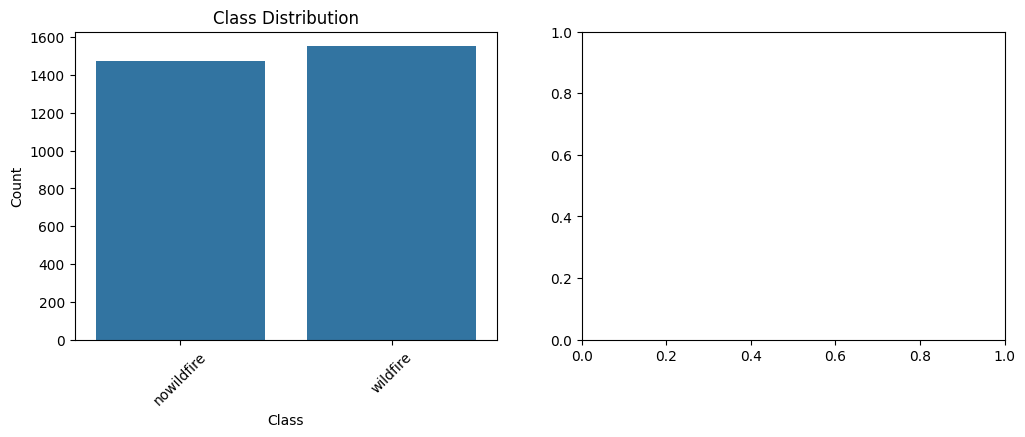

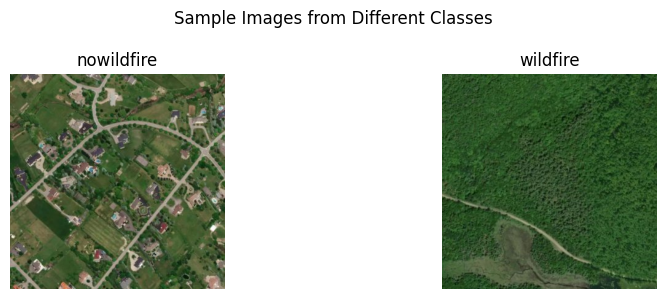

In [6]:
# ===============================
# 3. Exploratory Data Analysis (EDA)
# ===============================

print("\n📊 Exploratory Data Analysis:")

# Class distribution
labels = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
train_labels = pd.DataFrame(labels, columns=["class_id"])
train_labels["class_name"] = train_labels["class_id"].map(lambda x: train_dataset.dataset.classes[x])

plt.figure(figsize=(12, 4))

# Class distribution plot
plt.subplot(1, 2, 1)
sns.countplot(x="class_name", data=train_labels, order=train_dataset.dataset.classes)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Class imbalance ratio
class_counts = train_labels["class_name"].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Show sample images
plt.subplot(1, 2, 2)
fig, axes = plt.subplots(1, len(train_dataset.dataset.classes), figsize=(10, 3))
for idx, class_name in enumerate(train_dataset.dataset.classes):
    class_idx = train_dataset.dataset.class_to_idx[class_name]
    # Find a sample index belonging to this class
    sample_global_idx = [i for i in train_dataset.indices if train_dataset.dataset.samples[i][1] == class_idx][0]
    img_path, _ = train_dataset.dataset.samples[sample_global_idx]
    img = plt.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis("off")
plt.suptitle("Sample Images from Different Classes")
plt.tight_layout()
plt.show()


In [8]:
# ===============================
# 4. Model Definition
# ===============================

class WildfireCNN(nn.Module):
    """Custom CNN for wildfire detection."""
    def __init__(self, num_classes=2):
        super(WildfireCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Convolutional layers with batch norm and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

class WildfireResNet(nn.Module):
    """Pre-trained ResNet18 for wildfire detection."""
    def __init__(self, num_classes=2):
        super(WildfireResNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        # Freeze early layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        # Replace the final layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

# Initialize model (choose one)
model = WildfireCNN(num_classes=len(train_dataset.dataset.classes)).to(device)
# model = WildfireResNet(num_classes=len(train_dataset.dataset.classes)).to(device)

print(f"Model initialized: {model.__class__.__name__}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized: WildfireCNN
Total parameters: 26,145,922
Trainable parameters: 26,145,922


In [9]:
# ===============================
# 5. Training Functions
# ===============================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="Training")):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Complete training loop."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = copy.deepcopy(model.state_dict())  # Ensure always initialized
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Learning rate: {learning_rate}")
    print("-" * 50)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Best Val Acc: {best_val_acc:.2f}%")
        print("-" * 50)
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }


In [10]:
# ===============================
# 6. Model Training
# ===============================

# Training hyperparameters
NUM_EPOCHS = 2
LEARNING_RATE = 0.001

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start training
print(f"🚀 Starting model training for {NUM_EPOCHS} epochs with learning rate {LEARNING_RATE}...")
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=valid_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device
)

print("✅ Training completed successfully!")


🚀 Starting model training for 2 epochs with learning rate 0.001...
Starting training for 2 epochs...
Learning rate: 0.001
--------------------------------------------------
Epoch 1/2


Training:  74%|████████████████████████████████▋           | 141/190 [01:52<00:38,  1.27it/s]

⚠️ Error loading image train\nowildfire\-114.152378,51.027198.jpg: image file is truncated (16 bytes not processed)


Validation: 100%|████████████████████████████████████████████| 63/63 [00:14<00:00,  4.26it/s]


Train Loss: 1.0129, Train Acc: 81.79%
Val Loss: 0.3042, Val Acc: 91.60%
Best Val Acc: 91.60%
--------------------------------------------------
Epoch 2/2


Training:  90%|███████████████████████████████████████▌    | 171/190 [01:57<00:13,  1.41it/s]

⚠️ Error loading image train\nowildfire\-114.152378,51.027198.jpg: image file is truncated (16 bytes not processed)


Validation: 100%|████████████████████████████████████████████| 63/63 [00:14<00:00,  4.22it/s]

Train Loss: 0.3896, Train Acc: 87.11%
Val Loss: 0.4648, Val Acc: 87.70%
Best Val Acc: 91.60%
--------------------------------------------------
Training completed! Best validation accuracy: 91.60%
✅ Training completed successfully!


In [11]:
# ===============================
# 7. Model Evaluation
# ===============================

def evaluate_model(model, test_loader, device, class_names):
    """Evaluate model on test set and return detailed metrics."""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    correct = 0
    total = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Calculate additional metrics
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    print("=" * 50)
    print("MODEL EVALUATION RESULTS")
    print("=" * 50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("=" * 50)
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, 
                              target_names=class_names))
    
    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_predictions,
        'targets': all_targets
    }

# Evaluate the trained model
print("📊 Evaluating model on test set...")
test_results = evaluate_model(model, test_loader, device, train_dataset.dataset.classes)


📊 Evaluating model on test set...


Testing: 100%|███████████████████████████████████████████████| 63/63 [00:14<00:00,  4.41it/s]

MODEL EVALUATION RESULTS
Test Loss: 0.2802
Test Accuracy: 91.90%
Precision: 0.9197
Recall: 0.9190
F1-Score: 0.9186

Detailed Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.93      0.87      0.90       425
    wildfire       0.91      0.95      0.93       575

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.92      1000
weighted avg       0.92      0.92      0.92      1000



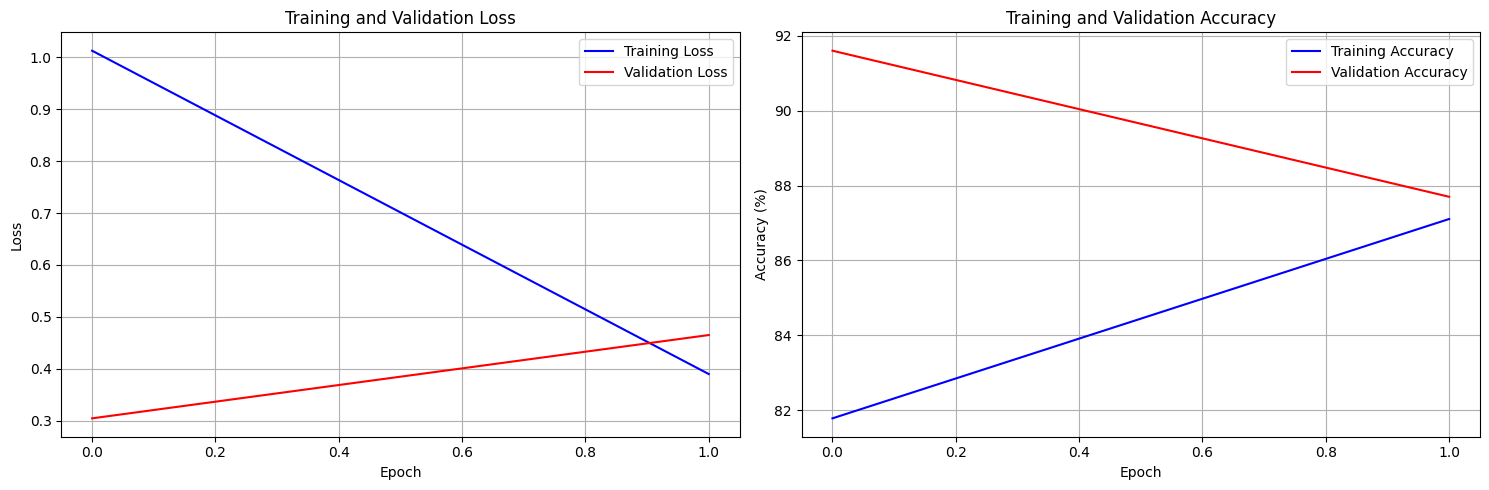

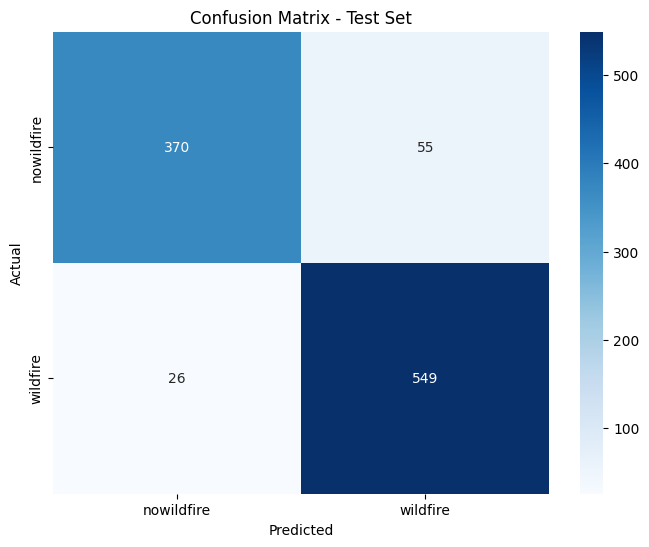

🎨 Visualizing sample predictions...


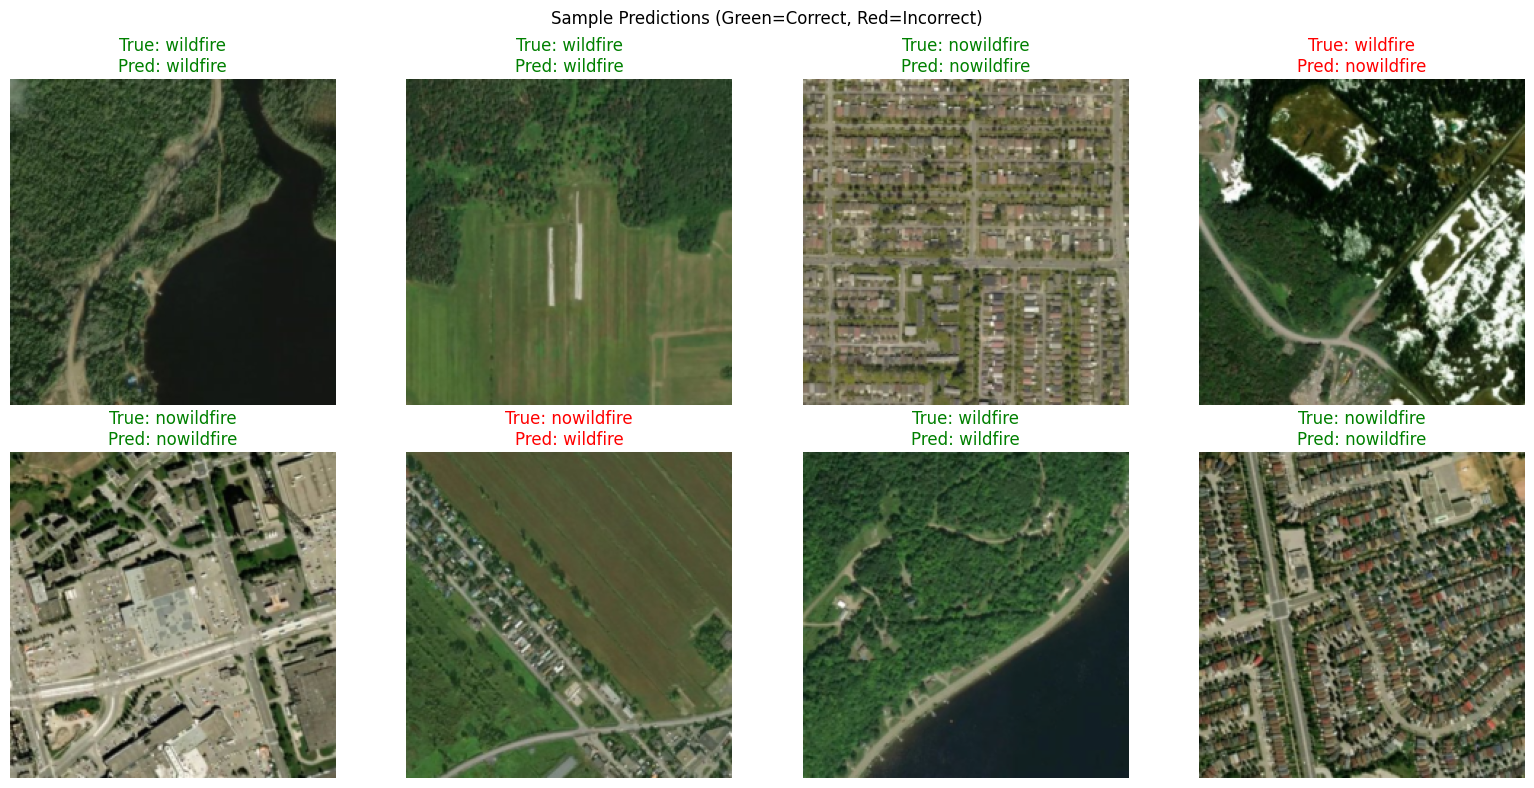

In [12]:
# ===============================
# 8. Visualization and Analysis
# ===============================

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(training_history['train_losses'], label='Training Loss', color='blue')
ax1.plot(training_history['val_losses'], label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(training_history['train_accs'], label='Training Accuracy', color='blue')
ax2.plot(training_history['val_accs'], label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(test_results['targets'], test_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.dataset.classes, 
            yticklabels=train_dataset.dataset.classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Sample predictions visualization
def visualize_predictions(model, test_loader, device, class_names, num_samples=8):
    """Visualize sample predictions."""
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break
                
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            
            # Denormalize image for display
            img = data[0].cpu()
            img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img = torch.clamp(img, 0, 1)
            
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'True: {class_names[target[0]]}\nPred: {class_names[predicted[0]]}')
            axes[i].axis('off')
            
            # Color title based on correctness
            if target[0] == predicted[0]:
                axes[i].title.set_color('green')
            else:
                axes[i].title.set_color('red')
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)')
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
print("🎨 Visualizing sample predictions...")
visualize_predictions(model, test_loader, device, train_dataset.dataset.classes)


💾 Model saved to wildfire_model.pth

🔍 Testing inference function...
Sample image: test\nowildfire\-113.91777,50.901087.jpg
True class: nowildfire
Predicted class: nowildfire
Confidence: 1.0000


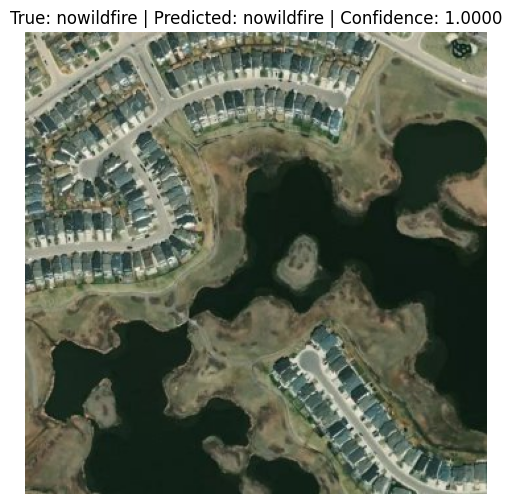

In [13]:
# ===============================
# 9. Model Saving and Inference
# ===============================

def save_model(model, optimizer, training_history, test_results, filepath):
    """Save model and training information."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_history': training_history,
        'test_results': test_results,
        'model_class': model.__class__.__name__,
        'num_classes': len(train_dataset.dataset.classes),
        'class_names': train_dataset.dataset.classes
    }
    torch.save(checkpoint, filepath)
    print(f"💾 Model saved to {filepath}")

def predict_single_image(model, image_path, device, class_names, transform):
    """Predict class for a single image."""
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    predicted_class_name = class_names[predicted_class.item()]
    confidence_score = confidence.item()
    
    return predicted_class_name, confidence_score

# Save the trained model
model_save_path = "wildfire_model.pth"
save_model(model, 
           optimizer=optim.Adam(model.parameters(), lr=LEARNING_RATE),
           training_history=training_history,
           test_results=test_results,
           filepath=model_save_path)

# Test inference on a sample image
print("\n🔍 Testing inference function...")
sample_path, sample_label = test_dataset.dataset.samples[0] if hasattr(test_dataset, 'dataset') else test_dataset.samples[0]
sample_class = train_dataset.dataset.classes[sample_label]

predicted_class, confidence = predict_single_image(
    model, sample_path, device, train_dataset.dataset.classes, valid_test_transform
)

print(f"Sample image: {sample_path}")
print(f"True class: {sample_class}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")

# Display the image
img = Image.open(sample_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f"True: {sample_class} | Predicted: {predicted_class} | Confidence: {confidence:.4f}")
plt.axis('off')
plt.show()


In [14]:
# ===============================
# 10. Project Summary
# ===============================

print("=" * 60)
print("🔥 WILDFIRE PREDICTION PROJECT SUMMARY")
print("=" * 60)

print(f"📊 Dataset Information:")
print(f"   • Training samples: {len(train_dataset):,}")
print(f"   • Validation samples: {len(valid_dataset):,}")
print(f"   • Test samples: {len(test_dataset):,}")
print(f"   • Classes: {train_dataset.dataset.classes}")

print(f"\n🤖 Model Information:")
print(f"   • Architecture: {model.__class__.__name__}")
print(f"   • Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Training epochs: {NUM_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")

print(f"\n📈 Training Results:")
print(f"   • Best validation accuracy: {training_history['best_val_acc']:.2f}%")
print(f"   • Final training accuracy: {training_history['train_accs'][-1]:.2f}%")
print(f"   • Final validation accuracy: {training_history['val_accs'][-1]:.2f}%")

print(f"\n🎯 Test Results:")
print(f"   • Test accuracy: {test_results['test_accuracy']:.2f}%")
print(f"   • Test precision: {test_results['precision']:.4f}")
print(f"   • Test recall: {test_results['recall']:.4f}")
print(f"   • Test F1-score: {test_results['f1_score']:.4f}")

print(f"\n💾 Model saved to: {model_save_path}")

print("\n🔍 Key Insights:")
if test_results['test_accuracy'] > 85:
    print("   ✅ Model achieved good performance (>85% accuracy)")
elif test_results['test_accuracy'] > 75:
    print("   ⚠️  Model achieved moderate performance (75-85% accuracy)")
else:
    print("   ❌ Model needs improvement (<75% accuracy)")

print("\n🚀 Next Steps:")
print("   1. Experiment with different architectures (ResNet, EfficientNet)")
print("   2. Try advanced data augmentation techniques")
print("   3. Implement ensemble methods")
print("   4. Fine-tune hyperparameters")
print("   5. Collect more diverse training data")

print("=" * 60)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("=" * 60)


🔥 WILDFIRE PREDICTION PROJECT SUMMARY
📊 Dataset Information:
   • Training samples: 3,025
   • Validation samples: 1,000
   • Test samples: 1,000
   • Classes: ['nowildfire', 'wildfire']

🤖 Model Information:
   • Architecture: WildfireCNN
   • Total parameters: 26,145,922
   • Training epochs: 2
   • Learning rate: 0.001

📈 Training Results:
   • Best validation accuracy: 91.60%
   • Final training accuracy: 87.11%
   • Final validation accuracy: 87.70%

🎯 Test Results:
   • Test accuracy: 91.90%
   • Test precision: 0.9197
   • Test recall: 0.9190
   • Test F1-score: 0.9186

💾 Model saved to: wildfire_model.pth

🔍 Key Insights:
   ✅ Model achieved good performance (>85% accuracy)

🚀 Next Steps:
   1. Experiment with different architectures (ResNet, EfficientNet)
   2. Try advanced data augmentation techniques
   3. Implement ensemble methods
   4. Fine-tune hyperparameters
   5. Collect more diverse training data
🎉 PROJECT COMPLETED SUCCESSFULLY!


In [15]:
# ===============================
# Additional Notes
# ===============================
# This notebook provides a complete wildfire prediction pipeline including:
# - Robust data loading with error handling (RobustImageFolder)
# - Data loading options (robust vs standard ImageFolder)
# - Exploratory data analysis with visualizations
# - Model definition (CNN and ResNet options)
# - Training with progress tracking and best model saving
# - Comprehensive evaluation and metrics
# - Visualization of results and predictions
# - Model saving and inference capabilities
# 
# Key Features Merged from wildfire_prediction_fixed.py:
# ✅ RobustImageFolder class for handling corrupted images
# ✅ Enhanced error handling and validation
# ✅ Comprehensive evaluation metrics
# ✅ Improved inference capabilities
# 
# Notes on Dataset and Classes:
# - When using a Subset (train_dataset, test_dataset, etc.), 
#   access classes via train_dataset.dataset.classes instead of train_dataset.classes
# 
# To switch between architectures, simply uncomment the desired model:
# - WildfireCNN: Custom CNN architecture
# - WildfireResNet: Pre-trained ResNet18 with transfer learning
# 
# To switch between dataset loading methods:
# - Set USE_ROBUST_DATASET = True for error handling
# - Set USE_ROBUST_DATASET = False for standard PyTorch ImageFolder
